<a href="https://colab.research.google.com/github/HadushHailu/discriminative_few_Shot_face_recognition_and_verification/blob/main/Face_Detector_comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configure environment**

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
colab_path = '/content/notebooks'
#os.symlink('/content/drive/My Drive/Colab Notebooks', colab_path)
sys.path.insert(0, colab_path)

In [ ]:
# Installing libraries
!pip install --target=$colab_path retina-face && pip install --target=$colab_path mtcnn && pip install --target=$colab_path openface

  Using cached retina_face-0.0.17-py3-none-any.whl (25 kB)
  Using cached mtcnn-0.1.1-py3-none-any.whl (2.3 MB)
  Using cached openface-0.0.0-py3-none-any.whl (2.5 kB)


In [ ]:
!pip install tensorflow

# **Import Libraries**

In [ ]:
import tensorflow as tf
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt

In [ ]:
from retinaface import RetinaFace

In [ ]:
## Restart session
# import os
# os.kill(os.getpid(), 9)

# **Photo capture**

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  # Detect faces in the image
  faces = RetinaFace.detect_faces(img)

  # Iterate over detected faces and draw bounding boxes
  for face_id, face_info in faces.items():
      facial_area = face_info['facial_area']
      score = face_info['score']

      x1, y1, x2, y2 = facial_area

      # Draw the bounding box
      cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

      # Prepare the label with the score
      label = f'Score: {score:.2f}'

      # Set font parameters
      font = cv2.FONT_HERSHEY_SIMPLEX
      font_scale = 0.5
      font_color = (255, 0, 0)
      font_thickness = 2

      # Calculate the position for the text
      text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
      text_x = x1
      text_y = y1 - 10 if y1 - 10 > 10 else y1 + text_size[1] + 10

      # Put the label above the bounding box
      cv2.putText(img, label, (text_x, text_y), font, font_scale, font_color, font_thickness)

  # Display the image with bounding boxes
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

24-05-24 19:33:46 - Directory /root/.deepface created
24-05-24 19:33:46 - Directory /root/.deepface/weights created
24-05-24 19:33:46 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:01<00:00, 110MB/s]


Saved to photo.jpg


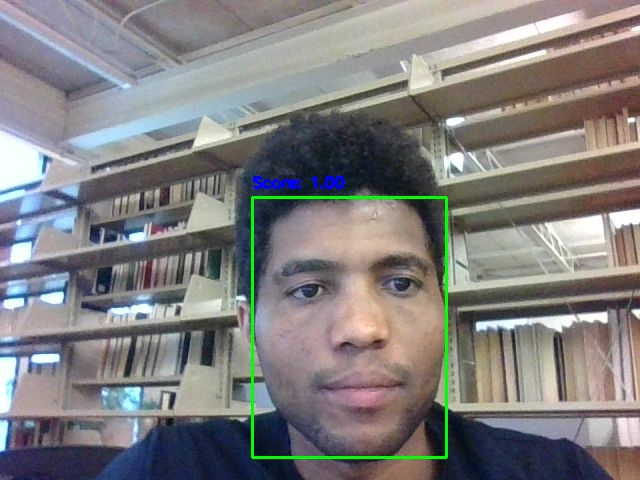

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# **Retina Face**

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
start = False
while start:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Detect faces in the image
    faces = RetinaFace.detect_faces(frame)

    # Iterate over detected faces and draw bounding boxes
    for face_id, face_info in faces.items():
        facial_area = face_info['facial_area']
        score = face_info['score']

        x1, y1, x2, y2 = facial_area

        # Draw the bounding box
        cv2.rectangle(bbox_array, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Prepare the label with the score
        label = f'Score: {score:.2f}'

        # Set font parameters
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 0, 0)
        font_thickness = 2

        # Calculate the position for the text
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > 10 else y1 + text_size[1] + 10

        # Put the label above the bounding box
        cv2.putText(bbox_array, label, (text_x, text_y), font, font_scale, font_color, font_thickness)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# **MTCNN**

In [ ]:
from mtcnn.mtcnn import MTCNN
# Initialize MTCNN detector
detector = MTCNN()

In [ ]:
from functools import wraps
import sys
import io
def capture_output(func):
    """Wrapper to capture print output."""

    @wraps(func)
    def wrapper(*args, **kwargs):
        old_stdout = sys.stdout
        new_stdout = io.StringIO()
        sys.stdout = new_stdout
        try:
            return func(*args, **kwargs)
        finally:
            sys.stdout = old_stdout

    return wrapper

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
start = False
while start:

    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Detect faces in the image
    w_detect_face = capture_output(detector.detect_faces)
    results = w_detect_face(frame)

    # Iterate over detected faces and draw bounding boxes
    for result in results:
        bounding_box = result['box']
        score = result['confidence']
        x, y, width, height = bounding_box
        x2, y2 = x + width, y + height

        # Draw the bounding box
        cv2.rectangle(bbox_array, (x, y), (x2, y2), (0, 255, 0), 2)

        # Prepare the label with the score
        label = f'Score: {score:.2f}'

        # Set font parameters
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        font_color = (255, 0, 0)
        font_thickness = 2

        # Calculate the position for the text
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        text_x = x
        text_y = y - 10 if y - 10 > 10 else y + text_size[1] + 10

        # Put the label above the bounding box
        cv2.putText(bbox_array, label, (text_x, text_y), font, font_scale, font_color, font_thickness)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# **OpenFace**

In [ ]:
import dlib
detector = dlib.get_frontal_face_detector()

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
start = False
while start:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Detect faces in the image
    faces = detector(frame)

    # Iterate over detected faces and draw bounding boxes
    for i, rect in enumerate(faces):
        x1, y1, x2, y2 = rect.left(), rect.top(), rect.right(), rect.bottom()

        # Draw the bounding box
        cv2.rectangle(bbox_array, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Prepare the label with the score
        label = f'Face {i+1}'

        # Set font parameters
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        font_color = (255, 0, 0)
        font_thickness = 2

        # Calculate the position for the text
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > 10 else y1 + text_size[1] + 10

        # Put the label above the bounding box
        cv2.putText(bbox_array, label, (text_x, text_y), font, font_scale, font_color, font_thickness)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>